In [2]:
import os
import numpy as np
import pandas as pd
import copy

os.chdir("/Users/burke/Documents/research/bpCog/mcm")
from mcm.outcome import OutcomeType
from mcm.population import NHANESDirectSamplePopulation
from mcm.smoking_status import SmokingStatus

In [3]:
# crudely filter for possible allhat candidates
def ageBPFilter(x):
    return x.age > 55 and x.meanSBP > 140 and x.meanSBP < 180 and x.meanDBP > 90 and x.meanDBP < 110

In [4]:
import copy
basePop99 =  NHANESDirectSamplePopulation(n=100000, year=1999, filter=ageBPFilter)
basePop01 =  NHANESDirectSamplePopulation(n=100000, year=2001, filter=ageBPFilter)
basePop03 = NHANESDirectSamplePopulation(n=100000, year=2003, filter=ageBPFilter)
basePop99._people = basePop99._people[basePop99._people.notnull()]
basePop01._people = basePop01._people[basePop01._people.notnull()]
basePop03._people = basePop03._people[basePop03._people.notnull()]

In [5]:
basePop = basePop99
basePop._people = basePop._people.append([basePop01._people,basePop03._people])

In [6]:
baselinePop = NHANESDirectSamplePopulation(n=100000, year=2001, filter=ageBPFilter) # start the sim in 2001
popExtraBpMed = NHANESDirectSamplePopulation(n=100000, year=2001, filter=ageBPFilter) # start the sim in 2001

In [7]:
clonedPeople = []
for i,person in basePop._people.iteritems():
    for copyCount in range (1,50):
        clonedPeople.append(person.slightly_randomly_modify_baseline_risk_factors(basePop._risk_model_repository))
baselinePop._people = pd.Series(clonedPeople)

clonedPeople2 = []
for i,person in basePop._people.iteritems():
    for copyCount in range (1,50):
        clonedPeople2.append(person.slightly_randomly_modify_baseline_risk_factors(basePop._risk_model_repository))
popExtraBpMed._people = pd.Series(clonedPeople2)

In [8]:
baselinePop._people = baselinePop._people[baselinePop._people.notnull()]
baselinePop._people = baselinePop._people.loc[[person.allhat_candidate(0) ==True for person in baselinePop._people]]
popExtraBpMed._people = popExtraBpMed._people[popExtraBpMed._people.notnull()]
popExtraBpMed._people = popExtraBpMed._people.loc[[person.allhat_candidate(0) ==True for person in popExtraBpMed._people]]

In [9]:
len(baselinePop._people)

64013

In [10]:
len(popExtraBpMed._people)

63997

### Setup a baseline population and one where <b>everybody</b> gets an additional BP med

In [11]:
# BP lowering effect from Turnbull, F., Blood Pressure Lowering Treatment Trialists' Collaboration. (2003). Effects of different blood-pressure-lowering regimens on major cardiovascular events: results of prospectively-designed overviews of randomised trials. Lancet, 362(9395), 1527–1535. http://doi.org/10.1016/S0140-6736(03)14739-3
# SBP is a weighted average of the 3 groups = 
weightedSBPLowering = (18229 * 5 + 7482 * 8 + 20888 * 4) / (18229 + 7482 + 20888)
weightedDBPLowering = (18229 * 2 + 7482 * 4 + 20888 * 3) / (18229 + 7482 + 20888)
print(f"average BP lowering: {weightedSBPLowering:.2f}/{weightedDBPLowering:.2f}")

average BP lowering: 5.03/2.77


In [12]:
def addABPMed(person):
    return {'_antiHypertensiveCount' : 1}, {'_sbp': - 1* weightedSBPLowering, '_dbp' : -1 * weightedDBPLowering}

popExtraBpMed.set_bp_treatment_strategy(addABPMed)

In [13]:
baselinePop.advance_multi_process(5)
popExtraBpMed.advance_multi_process(5)

0
1
2
3
4
0
1
2
3
4


### Check that BP and BP meds are the same at baseline

In [14]:
pd.Series([x._sbp[0] for i, x in  baselinePop._people.iteritems()]).mean()

161.83607021617928

In [15]:
pd.Series([x._sbp[0] for i, x in  popExtraBpMed._people.iteritems()]).mean()

161.8480075727636

### Check that BP and BP meds are suitably adjusted in both populations

In [16]:
pd.Series([x._sbp[1] for i, x in  baselinePop._people.iteritems()]).mean()

162.11229598194666

In [17]:
pd.Series([x._sbp[1] for i, x in  popExtraBpMed._people.iteritems()]).mean()

157.09127395518144

In [18]:
pd.Series([x._sbp[-1] for i, x in  baselinePop._people.iteritems()]).describe()

count    64013.000000
mean       161.722720
std         10.375273
min        137.173459
25%        153.091762
50%        161.726046
75%        170.054526
max        186.678690
dtype: float64

In [19]:
pd.Series([x._sbp[-1] for i, x in  popExtraBpMed._people.iteritems()]).describe()

count    63997.000000
mean       159.029874
std         10.354460
min        134.180101
25%        150.617409
50%        159.003194
75%        167.490397
max        184.080486
dtype: float64

In [20]:
print(f" # dead in regular population {pd.Series([x.is_dead() for i, x in  baselinePop._people.iteritems()]).sum()}")
print(f" # dead in lower BP population {pd.Series([x.is_dead() for i, x in  popExtraBpMed._people.iteritems()]).sum()}")



 # dead in regular population 9051
 # dead in lower BP population 8699


In [21]:
pd.Series([x._antiHypertensiveCount[0] for i, x in  baselinePop._people.iteritems()]).mean()

0.9905487947760611

In [22]:
pd.Series([x._antiHypertensiveCount[0] for i, x in  popExtraBpMed._people.iteritems()]).mean()

0.9905776833289061

In [23]:
pd.Series([x._antiHypertensiveCount[1] for i, x in  baselinePop._people.iteritems()]).mean()

1.0960429912673988

In [24]:
pd.Series([x._antiHypertensiveCount[1] for i, x in  popExtraBpMed._people.iteritems()]).mean()

2.094910698939013

In [25]:
pd.Series([x._antiHypertensiveCount[-1] for i, x in  baselinePop._people.iteritems()]).mean()

1.220361489072532

In [26]:
pd.Series([x._antiHypertensiveCount[-1] for i, x in  popExtraBpMed._people.iteritems()]).mean()

1.6562963888932294

### look at relative risk across age deciles

In [150]:
ageBpPop = pd.DataFrame({'mi': [x.has_mi_during_simulation() for i,x in  baselinePop._people.iteritems()],
                         'stroke' : [x.has_stroke_during_simulation() for i,x in  baselinePop._people.iteritems()],
                         'age' : [x._age[0] for i,x in  baselinePop._people.iteritems()],
                         'sbp' : [x._sbp[0] for i,x in  baselinePop._people.iteritems()],
                         'dbp' : [x._dbp[0] for i,x in  baselinePop._people.iteritems()],
                         'priorStrokeMI' : [x.has_stroke_prior_to_simulation() or x.has_mi_prior_to_simulation() for i,x in  baselinePop._people.iteritems()],
                         'currentSmoker' : [x._smokingStatus==SmokingStatus.CURRENT for i,x in  baselinePop._people.iteritems()],
                         'hdl' : [x._hdl[0] for i,x in  baselinePop._people.iteritems()],
                         'a1c' : [x._a1c[0] for i,x in  baselinePop._people.iteritems()],
                         'dead' : [x.is_dead() for i,x in  baselinePop._people.iteritems()],
                         'allhat' : [x.allhat_candidate(0) for i,x in  baselinePop._people.iteritems()],
                         'yearsOfObservation' : [x.years_in_simulation() for i, x in baselinePop._people.iteritems()]})

ageBpPop['ageDeciles'] = pd.qcut(ageBpPop.age, 5, labels=range(1,6))
ageBpPop['sbpDeciles'] = pd.qcut(ageBpPop.sbp, 5, labels=range(1,6))


ageBpTreatedPop = pd.DataFrame({'mi': [x.has_mi_during_simulation() for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke' : [x.has_stroke_during_simulation() for i,x in  popExtraBpMed._people.iteritems()],
                         'age' : [x._age[0] for i,x in  popExtraBpMed._people.iteritems()],
                         'sbp' : [x._sbp[0] for i,x in  popExtraBpMed._people.iteritems()],
                         'dbp' : [x._dbp[0] for i,x in  popExtraBpMed._people.iteritems()],
                         'priorStrokeMI' : [x.has_stroke_prior_to_simulation() or x.has_mi_prior_to_simulation() for i,x in  popExtraBpMed._people.iteritems()],
                         'currentSmoker' : [x._smokingStatus==SmokingStatus.CURRENT for i,x in  popExtraBpMed._people.iteritems()],
                         'hdl' : [x._hdl[0] for i,x in  popExtraBpMed._people.iteritems()],
                         'a1c' : [x._a1c[0] for i,x in  popExtraBpMed._people.iteritems()],
                         'dead' : [x.is_dead() for i,x in  popExtraBpMed._people.iteritems()],
                         'allhat' : [x.allhat_candidate(0) for i,x in  popExtraBpMed._people.iteritems()],
                         'yearsOfObservation' : [x.years_in_simulation() for i, x in popExtraBpMed._people.iteritems()]})


ageBpTreatedPop['ageDeciles'] = pd.qcut(ageBpTreatedPop.age, 5, labels=range(1,6))
ageBpTreatedPop['sbpDeciles'] = pd.qcut(ageBpTreatedPop.sbp, 5, labels=range(1,6))

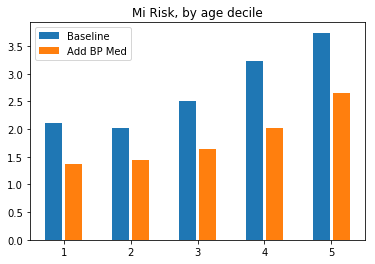

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(np.arange(0.85, 5.85, 1), ageBpPop.groupby('ageDeciles')['mi'].mean()*100, width=0.25, label = "Baseline")
plt.bar(np.arange(1.15, 6.15, 1), ageBpTreatedPop.groupby('ageDeciles')['mi'].mean()*100, width=0.25, label="Add BP Med")
plt.title("Mi Risk, by age decile")
plt.legend()

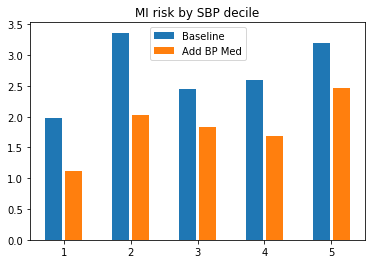

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(np.arange(0.85, 5.85, 1), ageBpPop.groupby('sbpDeciles')['mi'].mean()*100, width=0.25, label = "Baseline")
plt.bar(np.arange(1.15, 6.15, 1), ageBpTreatedPop.groupby('sbpDeciles')['mi'].mean()*100, width=0.25, label="Add BP Med")
plt.title("MI risk by SBP decile")
plt.legend()

Text(0.5,1,'Stroke Risk, by age decile')

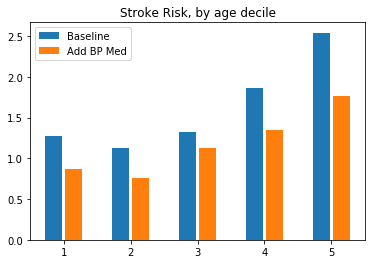

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(np.arange(0.85, 5.85, 1), ageBpPop.groupby('ageDeciles')['stroke'].mean()*100, width=0.25, label = "Baseline")
plt.bar(np.arange(1.15, 6.15, 1), ageBpTreatedPop.groupby('ageDeciles')['stroke'].mean()*100, width=0.25, label="Add BP Med")
plt.legend()
plt.title("Stroke Risk, by age decile")

Text(0.5,1,'Stroke Risk, by SBP decile')

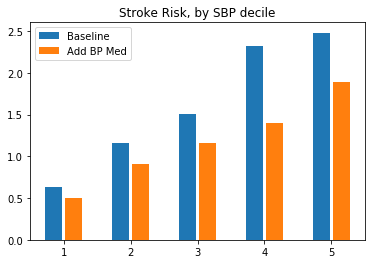

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(np.arange(0.85, 5.85, 1), ageBpPop.groupby('sbpDeciles')['stroke'].mean()*100, width=0.25, label = "Baseline")
plt.bar(np.arange(1.15, 6.15, 1), ageBpTreatedPop.groupby('sbpDeciles')['stroke'].mean()*100, width=0.25, label="Add BP Med")
plt.legend()
plt.title("Stroke Risk, by SBP decile")

In [32]:
print ("Relative MI risk reduction by age decile")
print((ageBpPop.groupby('ageDeciles')['mi'].mean() -ageBpTreatedPop.groupby('ageDeciles')['mi'].mean())/ageBpPop.groupby('ageDeciles')['mi'].mean())

print ("Relative stroke risk reduction by age decile")
print((ageBpPop.groupby('ageDeciles')['stroke'].mean() -ageBpTreatedPop.groupby('ageDeciles')['stroke'].mean())/ageBpPop.groupby('ageDeciles')['stroke'].mean())

Relative MI risk reduction by age decile
ageDeciles
1    0.349436
2    0.291341
3    0.348028
4    0.372285
5    0.291146
Name: mi, dtype: float64
Relative stroke risk reduction by age decile
ageDeciles
1    0.312485
2    0.325387
3    0.147549
4    0.274006
5    0.306934
Name: stroke, dtype: float64


In [33]:
ageBpPop.mean()

mi                 0.026870
stroke             0.015981
age               64.315295
sbp              161.836070
dbp               94.296093
priorStrokeMI      1.000000
currentSmoker      0.129302
hdl               53.542212
a1c                5.749683
dead               0.141393
allhat             1.000000
ageDeciles         2.925218
sbpDeciles         2.946386
dtype: float64

In [34]:
ageBpTreatedPop.mean()

mi                 0.017954
stroke             0.011501
age               64.308968
sbp              161.848008
dbp               94.302161
priorStrokeMI      1.000000
currentSmoker      0.129350
hdl               53.566115
a1c                5.745093
dead               0.135928
allhat             1.000000
ageDeciles         2.922512
sbpDeciles         2.948591
dtype: float64

Text(0.5,1,'MI Risk in allhat-type population')

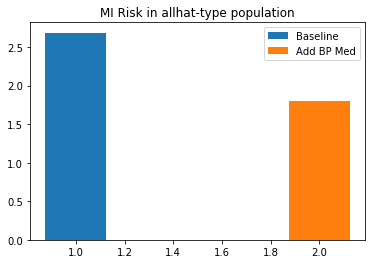

In [35]:
plt.bar(1, ageBpPop['mi'].mean()*100, width=0.25, label = "Baseline")
plt.bar(2, ageBpTreatedPop['mi'].mean()*100, width=0.25, label="Add BP Med")
plt.legend()
plt.title("MI Risk in allhat-type population")

Text(0.5,1,'Stroke Risk in allhat-type population')

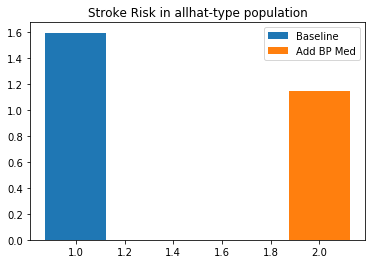

In [36]:
plt.bar(1, ageBpPop['stroke'].mean()*100, width=0.25, label = "Baseline")
plt.bar(2, ageBpTreatedPop['stroke'].mean()*100, width=0.25, label="Add BP Med")
plt.legend()
plt.title("Stroke Risk in allhat-type population")

In [156]:
print (f"Relative MI risk for one BP med in ALLHAT: {(ageBpTreatedPop['mi'].sum()/ageBpTreatedPop['yearsOfObservation'].sum())/(ageBpPop['mi'].sum()/ageBpTreatedPop['yearsOfObservation'].sum()):.2f}")
print (f"Relative stroke risk for one BP med in ALLHAT: {(ageBpTreatedPop['stroke'].sum()/ageBpTreatedPop['yearsOfObservation'].sum())/(ageBpPop['stroke'].sum()/ageBpTreatedPop['yearsOfObservation'].sum()):.2f}")

Relative MI risk for one BP med in ALLHAT: 0.67
Relative stroke risk for one BP med in ALLHAT: 0.72


### Across 4 runs of the simulatino, we got:
<ol>
    <li>Relative <b>MI</b> risk for one BP med in ALLHAT: 0.72
        <p>Relative <b>stroke</b> risk for one BP med in ALLHAT: 0.64
    </li>

<p>
<li>Relative <b>MI</b> risk for one BP med in ALLHAT: 0.73
    <p>Relative <b>stroke</b> risk for one BP med in ALLHAT: 0.74
</li>

<p><li>Relative <b>MI</b> risk for one BP med in ALLHAT: 0.66
    <p>Relative <b>stroke</b> risk for one BP med in ALLHAT: 0.67
</li>

<P><li>
    Relative <b>MI</b> risk for one BP med in ALLHAT: 0.75
    <p>Relative <b>stroke</b> risk for one BP med in ALLHAT: 0.70
</li>
</ol>

1.  for stroke, the relative risk should be around 0.62-0.77 — so we're over estimating risk by a little bit...
2. for MI, the relative risk shoudl be around 0.78-0.85...so, we're over estimating risk by quite a bit....

### conclusions
1. We're probably estimating the overall risk reasonably accurately, although perhpaps a little aggressively (we're around 0.72 for MI and 0.67 for sroke)
2. Our models aren't pickig up the role of blood pressure lowering for stroke >> MI

### questions
1. What is the right setup for a comparison? Duration? 
2. What is the right treamtent comparison, "add one med in year one...and then some people non-adhere over 5 years is the current model"
3. Could our divergence just be that our population is a bit differnet than ALLHAT? (In spite of the same inclusion criteria, we got a somewhat differnet sample...)
4. Coudl the divergence be for failing to account for mortality? Should I estimate HR censoring on death? Actually...its quite clear that I shoudl...let me do that...
5. Is the place to focus on the event partitioning model? Its basically just an age model (more strokes amongst the old, more MIs amongst the young...). Should we include BP treatment into the model (i.e. more treamtent = fewer strokes?)
6. How importance is getting this issue "right" for the BP cog results?

In [77]:
untreatedEvents = pd.DataFrame({'mi1': [x.has_mi_during_wave(0) for i,x in  baselinePop._people.iteritems()],
                         'mi2': [x.has_mi_during_wave(1) for i,x in  baselinePop._people.iteritems()],
                         'mi3': [x.has_mi_during_wave(2) for i,x in  baselinePop._people.iteritems()],
                         'mi4': [x.has_mi_during_wave(3) for i,x in  baselinePop._people.iteritems()],
                         'mi5': [x.has_mi_during_wave(4) for i,x in  baselinePop._people.iteritems()],
                         'stroke1': [x.has_stroke_during_wave(0) for i,x in  baselinePop._people.iteritems()],
                         'stroke2': [x.has_stroke_during_wave(1) for i,x in  baselinePop._people.iteritems()],
                         'stroke3': [x.has_stroke_during_wave(2) for i,x in  baselinePop._people.iteritems()],
                         'stroke4': [x.has_stroke_during_wave(3) for i,x in  baselinePop._people.iteritems()],
                         'stroke5': [x.has_stroke_during_wave(4) for i,x in  baselinePop._people.iteritems()],                         'age' : [x._age[0] for i,x in  baselinePop._people.iteritems()],
                         'dead1': [x.is_dead() and len(x._age)==1 for i,x in  baselinePop._people.iteritems()],
                         'dead2': [x.is_dead() and len(x._age)==2 for i,x in  baselinePop._people.iteritems()],
                         'dead3': [x.is_dead() and len(x._age)==3 for i,x in  baselinePop._people.iteritems()],
                         'dead4': [x.is_dead() and len(x._age)==4 for i,x in  baselinePop._people.iteritems()],
                         'dead5': [x.is_dead() and len(x._age)==5 for i,x in  baselinePop._people.iteritems()],                         
                         'age' : [x._age[0] for i,x in  baselinePop._people.iteritems()],
                         'allhat' : [x.allhat_candidate(0) for i,x in  baselinePop._people.iteritems()]})

treatedEvents = pd.DataFrame({'mi1': [x.has_mi_during_wave(0) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi2': [x.has_mi_during_wave(1) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi3': [x.has_mi_during_wave(2) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi4': [x.has_mi_during_wave(3) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi5': [x.has_mi_during_wave(4) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke1': [x.has_stroke_during_wave(0) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke2': [x.has_stroke_during_wave(1) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke3': [x.has_stroke_during_wave(2) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke4': [x.has_stroke_during_wave(3) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke5': [x.has_stroke_during_wave(4) for i,x in  popExtraBpMed._people.iteritems()],                         
                         'age' : [x._age[0] for i,x in  popExtraBpMed._people.iteritems()],
                         'dead1': [x.is_dead() and len(x._age)==1 for i,x in  popExtraBpMed._people.iteritems()],
                         'dead2': [x.is_dead() and len(x._age)==2 for i,x in  popExtraBpMed._people.iteritems()],
                         'dead3': [x.is_dead() and len(x._age)==3 for i,x in  popExtraBpMed._people.iteritems()],
                         'dead4': [x.is_dead() and len(x._age)==4 for i,x in  popExtraBpMed._people.iteritems()],
                         'dead5': [x.is_dead() and len(x._age)==5 for i,x in  popExtraBpMed._people.iteritems()],                         
                         'allhat' : [x.allhat_candidate(0) for i,x in  popExtraBpMed._people.iteritems()]})

In [82]:
untreatedEvents['treatment'] = 0
treatedEvents['treatment'] = 1
allEvents = pd.concat([untreatedEvents, treatedEvents], ignore_index=True)
allEvents['id'] = allEvents.index

In [139]:
reshapedLong = pd.wide_to_long(allEvents,stubnames=['mi', 'stroke', 'dead'], i='id', j='wave')
reshapedLong = reshapedLong.sort_index()
reshapedLong['waveAsColumn'] = reshapedLong.index.get_level_values('wave')
reshapedLong.loc[reshapedLong.dead, 'diedInWaveTemp'] = reshapedLong.waveAsColumn
reshapedLong['diedInWave'] = reshapedLong.groupby('id')['diedInWaveTemp'].max()
reshapedLong['diedInWave'] = reshapedLong.groupby(['id'])['diedInWaveTemp'].transform(max)
reshapedLong = reshapedLong.loc[reshapedLong.waveAsColumn <= reshapedLong.diedInWave]
reshapedLong.drop(['diedInWaveTemp', 'diedInWave'], axis='columns', inplace=True)

In [168]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(reshapedLong[['stroke', 'waveAsColumn', 'treatment']], duration_col='waveAsColumn', event_col='stroke', show_progress=False)
print(f"\nHR of treatment on stroke: {np.exp(cph.params_[0]):.2f}")

cph.fit(reshapedLong[['mi', 'waveAsColumn', 'treatment']], duration_col='waveAsColumn', event_col='mi', show_progress=False)
print(f"\nHR of treatment on MI: {np.exp(cph.params_[0]):.2f}")


#cph.print_summary()  # access the results using cph.summary


HR of treatment on stroke: 0.78

HR of treatment on MI: 0.68


### possible theories: 
<ol><li> applying a fixed point blood pressure lowering effect is unrealistic...we need to sample from distributions, although i doubt that changes things much...</li>
<li> is there a duaraiton effect here? the estimates are based off of multiple eyars...looking at one year might miss the boat because the highest risk peopel are jumping first...</li>
<li> population parameters don't line up with ALLHAT (our population is older, BPs are quite a bit higher here — so maybe we haven't gotten the population right. although, i'm not sure about the direction of the relative effcts, this may be workign in our favor</li>
<li> observational BP lowering estimates are fundamentally diconnected from trial based estimates (i.e. ASCVD is not calibrated with the trials - could directly test this with the model...</li>
<li> what does the specification of a causal effect mean here? does a BP med cause a 4 point constant reduction in your BP? does it lower your BP one and then you return to baseline?</li>
</ol>

In [38]:
from mcm.outcome import OutcomeType

eventsByAgeUntreated = pd.DataFrame({'stroke0' : [x.has_stroke_during_wave(0) for i,x in  baselinePop._people.iteritems()],
                         'stroke1' : [x.has_stroke_during_wave(1) for i,x in  baselinePop._people.iteritems()],
                         'stroke2' : [x.has_stroke_during_wave(2) for i,x in  baselinePop._people.iteritems()],
                         'stroke3' : [x.has_stroke_during_wave(3) for i,x in  baselinePop._people.iteritems()],
                         'stroke4' : [x.has_stroke_during_wave(4) for i,x in  baselinePop._people.iteritems()],
                         'mi0' : [x.has_mi_during_wave(0) for i,x in  baselinePop._people.iteritems()],
                         'mi1' : [x.has_mi_during_wave(1) for i,x in  baselinePop._people.iteritems()],
                         'mi2' : [x.has_mi_during_wave(2) for i,x in  baselinePop._people.iteritems()],
                         'mi3' : [x.has_mi_during_wave(3) for i,x in  baselinePop._people.iteritems()],
                         'mi4' : [x.has_mi_during_wave(4) for i,x in  baselinePop._people.iteritems()]})

eventsByAgeTreated = pd.DataFrame({'stroke0' : [x.has_stroke_during_wave(0) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke1' : [x.has_stroke_during_wave(1) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke2' : [x.has_stroke_during_wave(2) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke3' : [x.has_stroke_during_wave(3) for i,x in  popExtraBpMed._people.iteritems()],
                         'stroke4' : [x.has_stroke_during_wave(4) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi0' : [x.has_mi_during_wave(0) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi1' : [x.has_mi_during_wave(1) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi2' : [x.has_mi_during_wave(2) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi3' : [x.has_mi_during_wave(3) for i,x in  popExtraBpMed._people.iteritems()],
                         'mi4' : [x.has_mi_during_wave(4) for i,x in  popExtraBpMed._people.iteritems()]})


Text(0.5,1,'Stroke Rates by temporal wave with treatment')

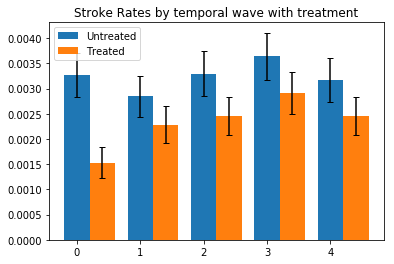

In [39]:
strokeUntreated = [eventsByAgeUntreated.stroke0.mean(),
                        eventsByAgeUntreated.stroke1.mean(),
                        eventsByAgeUntreated.stroke2.mean(),
                        eventsByAgeUntreated.stroke3.mean(),
                        eventsByAgeUntreated.stroke4.mean()]
strokeUntreatedError = np.array([eventsByAgeUntreated.stroke0.sem(),
                        eventsByAgeUntreated.stroke1.sem(),
                        eventsByAgeUntreated.stroke2.sem(),
                        eventsByAgeUntreated.stroke3.sem(),
                        eventsByAgeUntreated.stroke4.sem()])*1.96
strokeTreated = [eventsByAgeTreated.stroke0.mean(),
                        eventsByAgeTreated.stroke1.mean(),
                        eventsByAgeTreated.stroke2.mean(),
                        eventsByAgeTreated.stroke3.mean(),
                        eventsByAgeTreated.stroke4.mean()]
strokeTreatedError = np.array([eventsByAgeTreated.stroke0.sem(),
                        eventsByAgeTreated.stroke1.sem(),
                        eventsByAgeTreated.stroke2.sem(),
                        eventsByAgeTreated.stroke3.sem(),
                        eventsByAgeTreated.stroke4.sem()])*1.96

plt.bar(np.arange(0,5),strokeUntreated ,yerr=strokeUntreatedError, width=0.4, capsize=3,label="Untreated")
plt.bar(np.arange(0.4,5.4, 1), strokeTreated, yerr=strokeTreatedError, width=0.4, capsize=3, label="Treated")
plt.legend(loc=2)
plt.title("Stroke Rates by temporal wave with treatment")

In [39]:
pd.Series(strokeTreated)/pd.Series(strokeUntreated)

0    0.525831
1    0.731114
2    0.753403
3    0.770199
4    0.695305
dtype: float64

Text(0.5,1,'MI Rates by temporal wave with treatment')

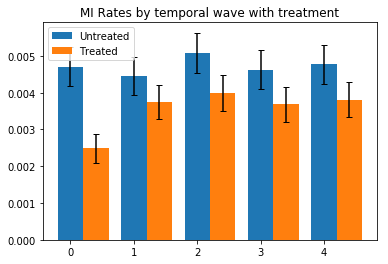

In [40]:
miUntreated = [eventsByAgeUntreated.mi0.mean(),
                        eventsByAgeUntreated.mi1.mean(),
                        eventsByAgeUntreated.mi2.mean(),
                        eventsByAgeUntreated.mi3.mean(),
                        eventsByAgeUntreated.mi4.mean()]

miUntreatedError = np.array([eventsByAgeUntreated.mi0.sem(),
                        eventsByAgeUntreated.mi1.sem(),
                        eventsByAgeUntreated.mi2.sem(),
                        eventsByAgeUntreated.mi3.sem(),
                        eventsByAgeUntreated.mi4.sem()])*1.96
miTreated = [eventsByAgeTreated.mi0.mean(),
                        eventsByAgeTreated.mi1.mean(),
                        eventsByAgeTreated.mi2.mean(),
                        eventsByAgeTreated.mi3.mean(),
                        eventsByAgeTreated.mi4.mean()]
miTreatedError = np.array([eventsByAgeTreated.mi0.sem(),
                        eventsByAgeTreated.mi1.sem(),
                        eventsByAgeTreated.mi2.sem(),
                        eventsByAgeTreated.mi3.sem(),
                        eventsByAgeTreated.mi4.sem()])*1.96

plt.bar(np.arange(0,5), miUntreated, yerr=miUntreatedError, width=0.4, capsize=3, label="Untreated")
plt.bar(np.arange(0.4,5.4, 1), miTreated, yerr=miTreatedError, width=0.4, capsize=3, label="Treated")
plt.legend(loc=2)
plt.title("MI Rates by temporal wave with treatment")

In [41]:
pd.Series(miTreated)/pd.Series(miUntreated)

0    0.527752
1    0.841329
2    0.783892
3    0.796563
4    0.799263
dtype: float64